# STEP 1 : Introduction au Projet

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50, VGG19, MobileNet
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import cv2
import random
from PIL import Image
from IPython.display import display

import warnings
warnings.filterwarnings("ignore") 

In [2]:
# Introduction au dataset GTSRB
path_train = '/kaggle/input/gtsrb-german-traffic-sign/Train.csv'
path_test = '/kaggle/input/gtsrb-german-traffic-sign/Test.csv'

# Charger les métadonnées dans des DataFrames
train_df = pd.read_csv(path_train)
test_df = pd.read_csv(path_test)

# Aperçu des premières lignes
print("Training Data:")
print(train_df.head())
print("\nTesting Data:")
print(test_df.head())

Training Data:
   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     27      26       5       5      22      20       20   
1     28      27       5       6      23      22       20   
2     29      26       6       5      24      21       20   
3     28      27       5       6      23      22       20   
4     28      26       5       5      23      21       20   

                             Path  
0  Train/20/00020_00000_00000.png  
1  Train/20/00020_00000_00001.png  
2  Train/20/00020_00000_00002.png  
3  Train/20/00020_00000_00003.png  
4  Train/20/00020_00000_00004.png  

Testing Data:
   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId            Path
0     53      54       6       5      48      49       16  Test/00000.png
1     42      45       5       5      36      40        1  Test/00001.png
2     48      52       6       6      43      47       38  Test/00002.png
3     27      29       5       5      22      24       33  Test/00003.png
4     60      57 

# STEP 2 : Préparation des données pour l'exploration

In [3]:
# Définition des constantes
IMG_HEIGHT, IMG_WIDTH = 32, 32  # Standard size for CNNs
NUM_CLASSES = 43  # Total number of traffic sign classes

# Fonction pour charger et prétraiter les images
def load_and_preprocess_image(path, img_size=(IMG_HEIGHT, IMG_WIDTH)):
    img = cv2.imread(f'/kaggle/input/gtsrb-german-traffic-sign/{path}')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, img_size)  # Resize to target size
    img = img / 255.0  # Normalize pixel values to [0, 1]
    return img

# Diviser le dataset en ensembles d'entraînement, de validation et de test
X_train = np.array([load_and_preprocess_image(path) for path in train_df['Path']])
y_train = train_df['ClassId'].values

# One-hot encode labels
y_train = to_categorical(y_train, NUM_CLASSES)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("Training Data Shape:", X_train.shape)
print("Validation Data Shape:", X_val.shape)

Training Data Shape: (31367, 32, 32, 3)
Validation Data Shape: (7842, 32, 32, 3)


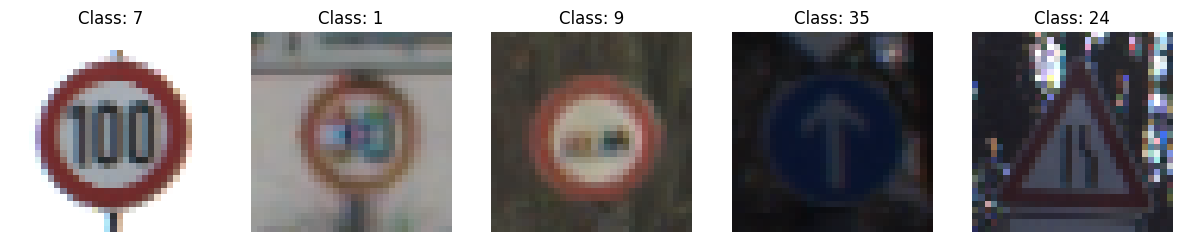

In [4]:
# Fonction pour afficher des échantillons d'images
def plot_sample_images(data, labels, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        idx = random.randint(0, len(data) - 1)
        axes[i].imshow(data[idx])
        axes[i].set_title(f"Class: {np.argmax(labels[idx])}")
        axes[i].axis('off')
    plt.show()

# Afficher des échantillons d'images d'entraînement
plot_sample_images(X_train, y_train)

# STEP 3 : Conception et Implémentation du Modèle CNN

In [5]:
# Définir les fonctions d'évaluation du modèle
def evaluate_model(model, X_test, y_test):
    """
    Évaluer le modèle sur les données de test et afficher la précision et la perte.

    Args:
        model: Modèle Keras entraîné.
        X_test: Données de test (numpy array).
        y_test: Vraies étiquettes (one-hot encoded numpy array).
    """
    # Calculer la précision et la perte
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
    print(f"Test Loss: {test_loss:.4f}")

def plot_training_curves(history):
    """
    Tracer les courbes de précision et de perte pour l'entraînement et la validation.

    Args:
        history: Objet History retourné par model.fit().
    """
    # Extraire les métriques de l'historique
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    # Tracer la précision
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Tracer la perte
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [6]:
# Définir le modèle CNN
cnn = Sequential([
    # block 1
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    # block 2
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # block 3
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dense(43, activation='softmax')
])

# Compiler le modèle
cnn.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Afficher le résumé du modèle
cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 43)                  │          11,051 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 235,627 (920.42 KB)

 Trainable params: 235,627 (920.42 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.2713 - loss: 2.6949 - val_accuracy: 0.8062 - val_loss: 0.6447
Epoch 2/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8751 - loss: 0.4193 - val_accuracy: 0.9331 - val_loss: 0.2258
Epoch 3/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9459 - loss: 0.1898 - val_accuracy: 0.9645 - val_loss: 0.1325
Epoch 4/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9776 - loss: 0.0833 - val_accuracy: 0.9719 - val_loss: 0.1039
Epoch 5/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9807 - loss: 0.0660 - val_accuracy: 0.9663 - val_loss: 0.1188
Epoch 6/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9795 - loss: 0.0750 - val_accuracy: 0.9783 - val_loss: 0.0886
Epoch 7/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9888 - loss: 0.0363 - val_accuracy: 0.9801 - val_loss: 0.0782
Epoch 8/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9942 - loss: 0.0230 - val_accuracy: 0.

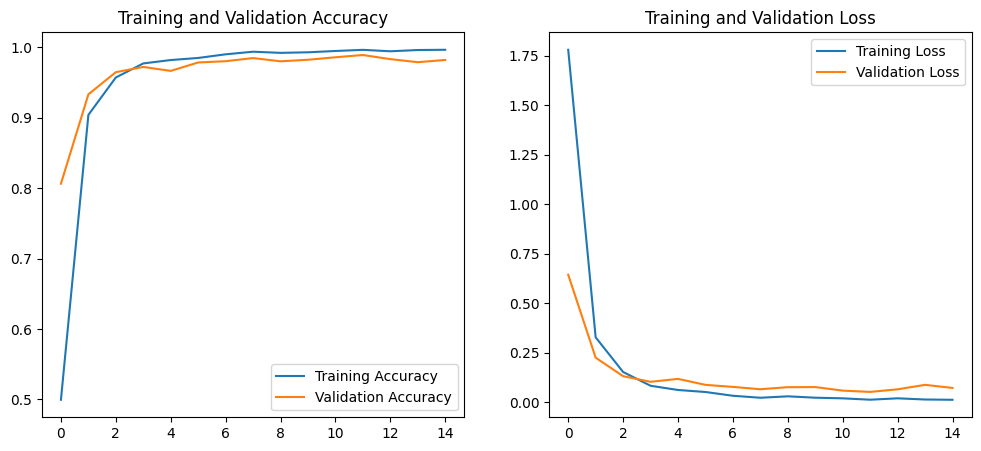

In [7]:
# Entraîner le modèle
history = cnn.fit(X_train, y_train, epochs=15,
                  batch_size=64, validation_data=(X_val, y_val))

# Évaluer le modèle
evaluate_model(cnn, X_val, y_val)
plot_training_curves(history)

# STEP 4 : Entraînement du Modèle sur données augmentées

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 15, 15, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 6, 6, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 2, 2, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 43)                  │          11,051 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 236,523 (923.92 KB)

 Trainable params: 236,075 (922.17 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/15
490/490 ━━━━━━━━━━━━━━━━━━━━ 29s 46ms/step - accuracy: 0.2803 - loss: 2.6715 - val_accuracy: 0.2289 - val_loss: 3.2561 - learning_rate: 0.0010
Epoch 2/15
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - accuracy: 0.5938 - loss: 1.1700 - val_accuracy: 0.2216 - val_loss: 3.3733 - learning_rate: 0.0010
Epoch 3/15
490/490 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.6152 - loss: 1.1668 - val_accuracy: 0.8435 - val_loss: 0.4574 - learning_rate: 0.0010
Epoch 4/15
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - accuracy: 0.6562 - loss: 0.9862 - val_accuracy: 0.8486 - val_loss: 0.4439 - learning_rate: 0.0010
Epoch 5/15
490/490 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.7245 - loss: 0.8123 - val_accuracy: 0.8849 - val_loss: 0.3361 - learning_rate: 0.0010
Epoch 6/15
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - accuracy: 0.6719 - loss: 0.8516 - val_accuracy: 0.8834 - val_loss: 0.3372 - learning_rate: 0.0010
Epoch 7/15
490/490 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.7823 - l

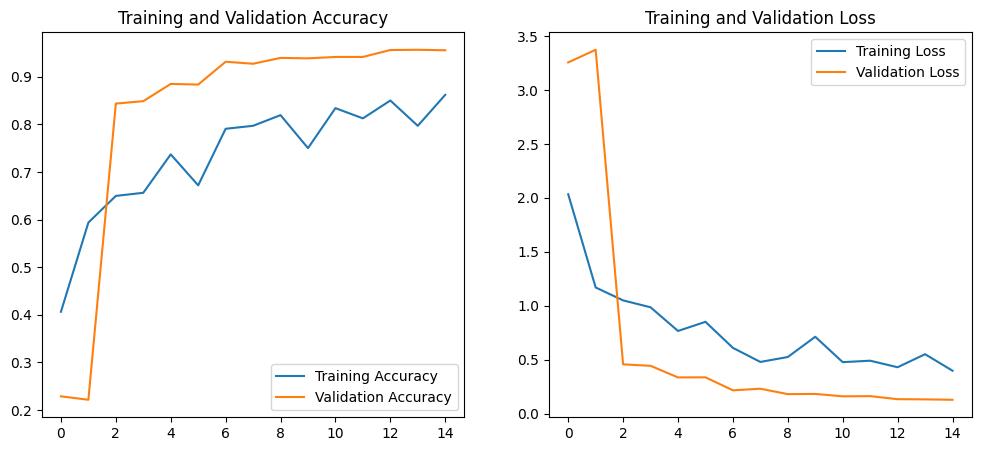

In [8]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,       # Randomly rotate images by up to 10 degrees
    width_shift_range=0.1,   # Randomly shift images horizontally by 10%
    height_shift_range=0.1,  # Randomly shift images vertically by 10%
    zoom_range=0.2,          # Randomly zoom in on images by up to 20%
    horizontal_flip=True,    # Randomly flip images horizontally
    fill_mode='nearest'      # Fill missing pixels after transformations
)

# Fit the generator on the training data
datagen.fit(X_train)
it_train = datagen.flow(X_train, y_train, batch_size=64)

# Définir le modèle avec les données augmentées
model_2 = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3), name='conv2d_1'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Dropout(0.4),

    Conv2D(64, kernel_size=(3, 3), activation='relu', name='conv2d_2'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Dropout(0.3),

    Conv2D(128, kernel_size=(3, 3), activation='relu', name='conv2d_3'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Dropout(0.2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(43, activation='softmax')
])

# Compiler le modèle
model_2.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Afficher le résumé du modèle
model_2.summary()

# Définir les callbacks pour early stopping et learning rate reduction
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Entraîner le modèle
history_2 = model_2.fit(it_train, epochs=15,
                  steps_per_epoch=len(X_train) // 64,
                  validation_data=(X_val, y_val), 
                  callbacks=[early_stopping, reduce_lr])

# Évaluer le modèle
evaluate_model(model_2, X_val, y_val)
plot_training_curves(history_2)


# STEP 5 : Évaluation du Modèle

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


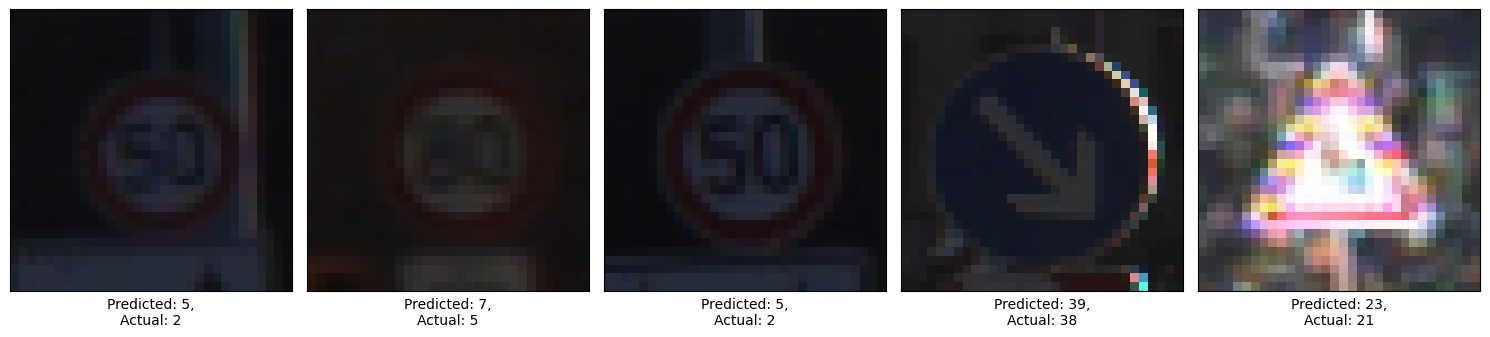

In [9]:
# Prédictions du modèle
y_pred = model_2.predict(X_val)

# Fonction pour afficher des images mal classées avec les indices des classes
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
misclassified_samples = np.nonzero(np.argmax(y_val, axis=1) != np.argmax(y_pred, axis=1))[0]
for nr, i in enumerate(misclassified_samples[:5]):
    axes[nr].imshow(X_val[i])
    predicted_class = np.argmax(y_pred[i])  # classe prédite
    actual_class = np.argmax(y_val[i])     # classe réelle
    axes[nr].set_xlabel(f"Predicted: {predicted_class},\nActual: {actual_class}")
    axes[nr].set_xticks([]), axes[nr].set_yticks([])

plt.tight_layout()
plt.show()


Précision: 0.9535
Rappel: 0.9514
F1-score: 0.9500


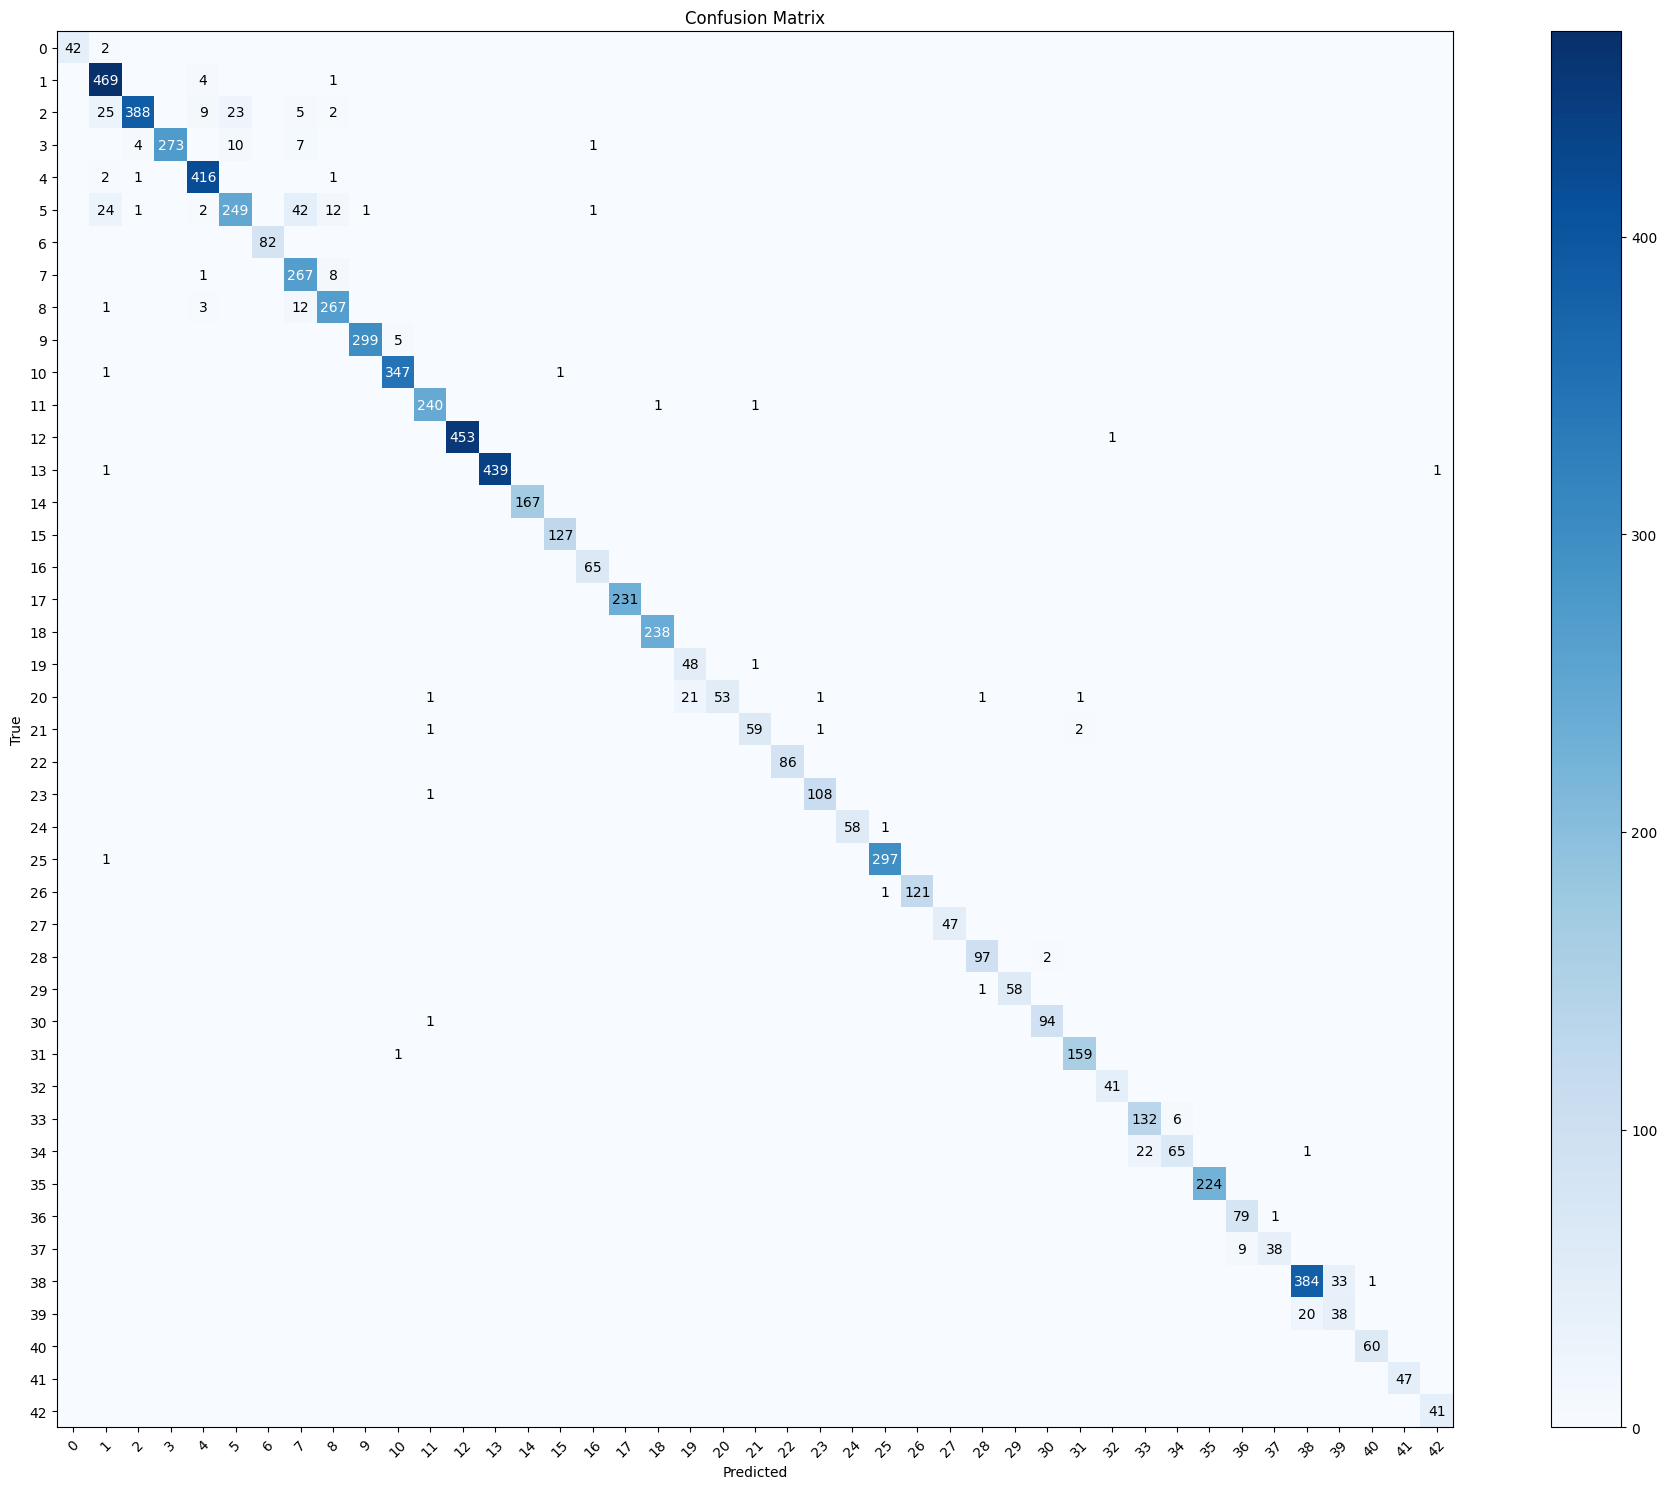

In [10]:
# Calculer des métriques de performance
from sklearn.metrics import precision_score, recall_score, f1_score

# Précision
precision = precision_score(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1), average='macro')
# Rappel
recall = recall_score(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1), average='macro')
# F1-score
f1 = f1_score(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1), average='macro')

print(f"Précision: {precision:.4f}")
print(f"Rappel: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Générer une matrice de confusion pour visualiser les erreurs de classification
cm = confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))
num_classes = 43
plt.figure(figsize=(20, 15))
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xticks(np.arange(num_classes), rotation=45)
plt.yticks(np.arange(num_classes))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Ajouter des valeurs numériques dans la matrice
threshold = cm.max() / 2
for i in range(num_classes):
    for j in range(num_classes):
        if cm[i, j] > 0:
            plt.text(j, i, cm[i, j], ha="center", va="center",
                     color="white" if cm[i, j] > threshold else "black")

plt.tight_layout()
plt.show()

# STEP 6: Améliorations et Expérimentations

In [11]:
!pip install -q -U keras-tuner

Trial 5 Complete [00h 00m 48s]
val_accuracy: 0.991073727607727

Best val_accuracy So Far: 0.9961744546890259
Total elapsed time: 00h 03m 18s
Meilleurs hyperparamètres :
  - Filtres: 64
  - Dropout: 0.2
  - Unités: 512
  - Learning rate: 0.0001
Epoch 1/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.5263 - loss: 1.8256 - val_accuracy: 0.9541 - val_loss: 0.2039 - learning_rate: 1.0000e-04
Epoch 2/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9266 - loss: 0.2531 - val_accuracy: 0.9828 - val_loss: 0.0723 - learning_rate: 1.0000e-04
Epoch 3/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9712 - loss: 0.1063 - val_accuracy: 0.9895 - val_loss: 0.0401 - learning_rate: 1.0000e-04
Epoch 4/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9830 - loss: 0.0610 - val_accuracy: 0.9931 - val_loss: 0.0270 - learning_rate: 1.0000e-04
Epoch 5/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9888 - loss: 0.0400 - val_accuracy: 0.9935 - val_loss: 0.0272 - l

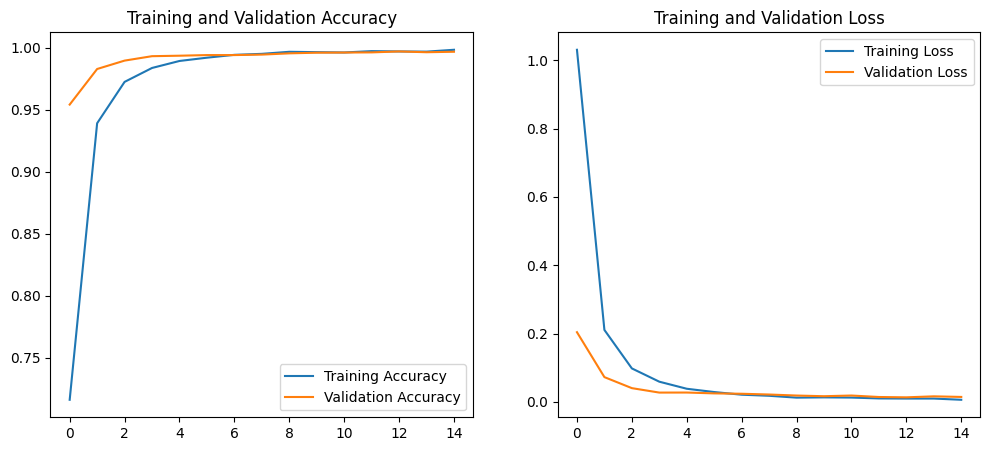

In [12]:
# Importer keras-tuner pour l'optimisation des hyperparamètres
# !pip install -q -U keras-tuner
import keras_tuner as kt
from tensorflow.keras import layers, models

def build_model(hp):
    model = models.Sequential()

    # Tune the number of units in the convolutional layers
    hp_filters = hp.Int('filters', min_value=32, max_value=128, step=32)
    
    # First convolutional block
    model.add(layers.Conv2D(hp_filters, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.BatchNormalization())
    
    # Tune the dropout rate
    hp_dropout = hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)
    model.add(layers.Dropout(hp_dropout))
    
    # Second convolutional block
    model.add(layers.Conv2D(hp_filters*2, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(hp_dropout))

    model.add(layers.Flatten())
    
    # Tune the units in the dense layer
    hp_units = hp.Int('units', min_value=128, max_value=512, step=64)
    model.add(layers.Dense(hp_units, activation='relu'))
    model.add(layers.Dropout(hp_dropout))
    model.add(layers.Dense(43, activation='softmax'))  # Output layer with softmax for 43 classes

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Initialiser le tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='tuner_results',
    project_name='traffic_sign_classification'
)

# Recherche des meilleurs hyperparamètres
tuner.search(X_train, y_train, 
             epochs=10, 
             validation_data=(X_val, y_val),
             callbacks=[early_stopping])

# Obtenir les hyperparamètres optimaux
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Meilleurs hyperparamètres :")
print(f"  - Filtres: {best_hps.get('filters')}")
print(f"  - Dropout: {best_hps.get('dropout')}")
print(f"  - Unités: {best_hps.get('units')}")
print(f"  - Learning rate: {best_hps.get('learning_rate')}")

# Construire et entraîner le modèle avec les meilleurs hyperparamètres
best_model = tuner.hypermodel.build(best_hps)
history_best = best_model.fit(
    X_train, y_train,
    epochs=15,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr]
)

# Évaluer le modèle
evaluate_model(best_model, X_val, y_val)
plot_training_curves(history_best)


# STEP 7 : Interprétation et Visualisation des Résultats

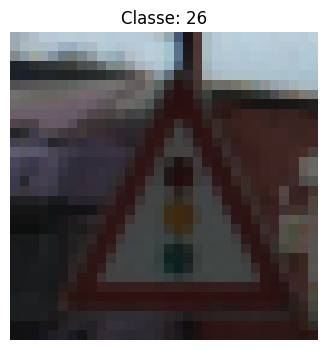

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


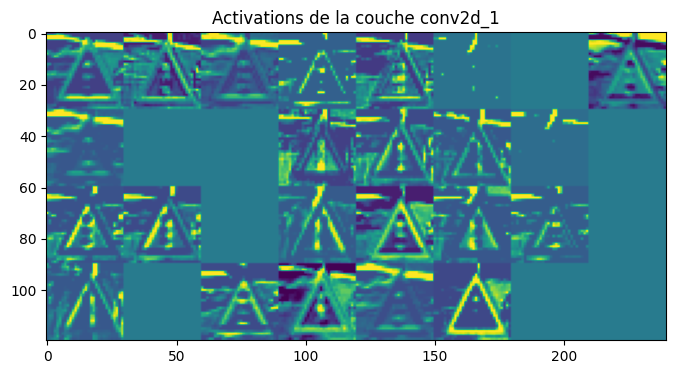

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


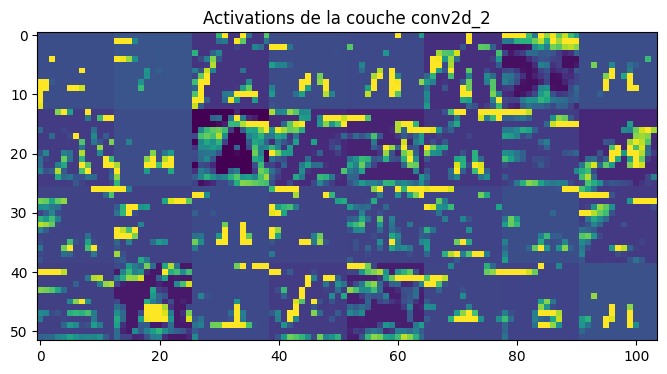

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


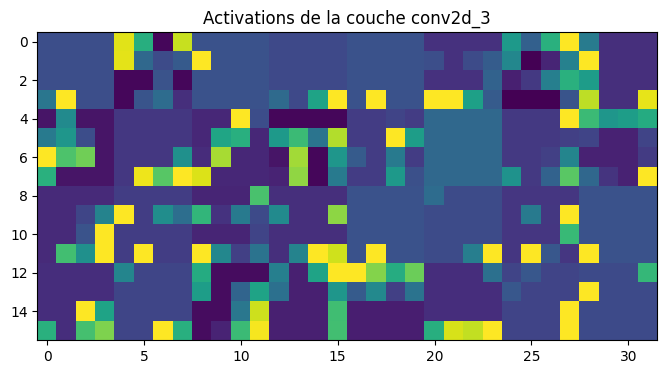

In [13]:
# Visualiser les activations des couches du modèle
def plot_layer_activations(model, img, layer_name, images_per_row=8):
    """
    Visualiser les activations d'une couche spécifique pour une image donnée
    """
    # Trouver la couche par son nom
    target_layer = None
    for layer in model.layers:
        if layer.name == layer_name:
            target_layer = layer
            break
    
    if target_layer is None:
        print(f"Couche {layer_name} non trouvée dans le modèle")
        return
    
    # Créer un modèle qui prend l'entrée du modèle original et sort la sortie de la couche cible
    activation_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=target_layer.output
    )
    
    # Préparer l'image (ajouter la dimension batch)
    img_tensor = np.expand_dims(img, axis=0)
    
    # Calculer les activations
    layer_activation = activation_model.predict(img_tensor)
    
    # Nombre de filtres dans la couche
    n_features = layer_activation.shape[-1]
    
    # Les dimensions de la carte de caractéristiques
    size = layer_activation.shape[1]
    
    # Nombre de colonnes dans notre grille d'affichage
    n_cols = min(n_features // images_per_row + (1 if n_features % images_per_row > 0 else 0), 4)  # Limiter à 4 colonnes max
    
    # Initialiser la grille d'affichage
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    # Remplir la grille avec des images de chaque filtre
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col * images_per_row + row
            if channel_index < n_features:
                channel_image = layer_activation[0, :, :, channel_index]
                
                # Normalisation pour l'affichage
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std() + 1e-5
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                
                # Placer l'image dans la grille
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
            else:
                # Sortir de la boucle si nous avons dépassé le nombre de caractéristiques
                break
    
    # Ajuster la taille de la grille si nécessaire
    if n_features < n_cols * images_per_row:
        display_grid = display_grid[:, :size * min(n_features, images_per_row)]
    
    # Afficher la grille
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(f"Activations de la couche {layer_name}")
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    plt.show()

# Sélectionner une image pour visualiser les activations
sample_idx = np.random.randint(0, len(X_val))
sample_img = X_val[sample_idx]
sample_label = np.argmax(y_val[sample_idx])

plt.figure(figsize=(4, 4))
plt.imshow(sample_img)
plt.title(f"Classe: {sample_label}")
plt.axis('off')
plt.show()

# Visualiser les activations des couches de convolution
plot_layer_activations(model_2, sample_img, 'conv2d_1', images_per_row=8)
plot_layer_activations(model_2, sample_img, 'conv2d_2', images_per_row=8)
plot_layer_activations(model_2, sample_img, 'conv2d_3', images_per_row=8)

# STEP 8 : Transfer Learning avec VGG19

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,166,763 (76.93 MB)

 Trainable params: 142,379 (556.17 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

Epoch 1/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 27s 47ms/step - accuracy: 0.2426 - loss: 2.7305 - val_accuracy: 0.4708 - val_loss: 1.7713 - learning_rate: 0.0010
Epoch 2/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4844 - loss: 1.8220 - val_accuracy: 0.4691 - val_loss: 1.7677 - learning_rate: 0.0010
Epoch 3/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.4247 - loss: 1.8799 - val_accuracy: 0.5022 - val_loss: 1.5657 - learning_rate: 0.0010
Epoch 4/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5781 - loss: 1.4250 - val_accuracy: 0.5010 - val_loss: 1.5633 - learning_rate: 0.0010
Epoch 5/10
490/490 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.4731 - loss: 1.6904 - val_accuracy: 0.5492 - val_loss: 1.4174 - learning_rate: 0.0010
Test Accuracy: 47.08%
Test Loss: 1.7713


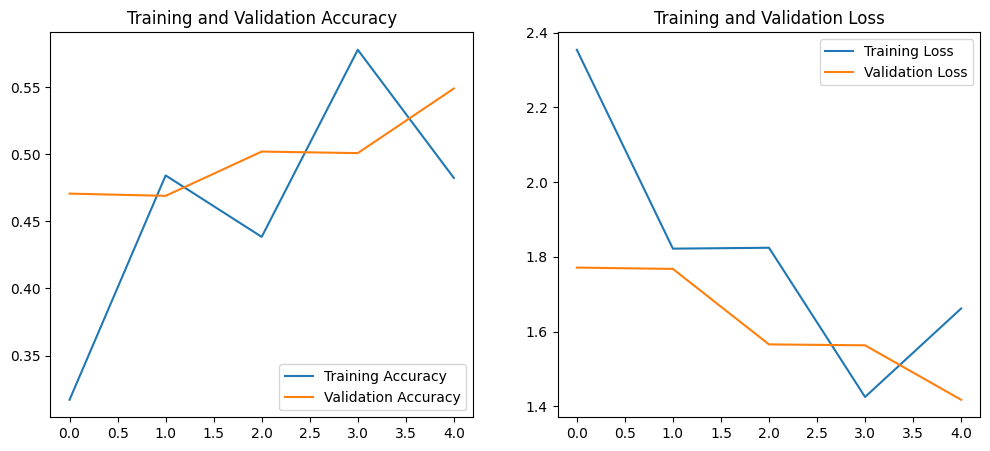

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,166,763 (76.93 MB)

 Trainable params: 7,221,803 (27.55 MB)

 Non-trainable params: 12,944,960 (49.38 MB)

Epoch 1/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4538 - loss: 1.7229 - val_accuracy: 0.6496 - val_loss: 1.0622 - learning_rate: 1.0000e-04
Epoch 2/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6562 - loss: 0.9868 - val_accuracy: 0.6575 - val_loss: 1.0499 - learning_rate: 1.0000e-04
Epoch 3/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.6134 - loss: 1.1811 - val_accuracy: 0.7237 - val_loss: 0.8349 - learning_rate: 1.0000e-04
Epoch 4/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6406 - loss: 1.1241 - val_accuracy: 0.7226 - val_loss: 0.8360 - learning_rate: 1.0000e-04
Epoch 5/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.6841 - loss: 0.9548 - val_accuracy: 0.7869 - val_loss: 0.6559 - learning_rate: 1.0000e-04
Test Accuracy: 64.96%
Test Loss: 1.0622


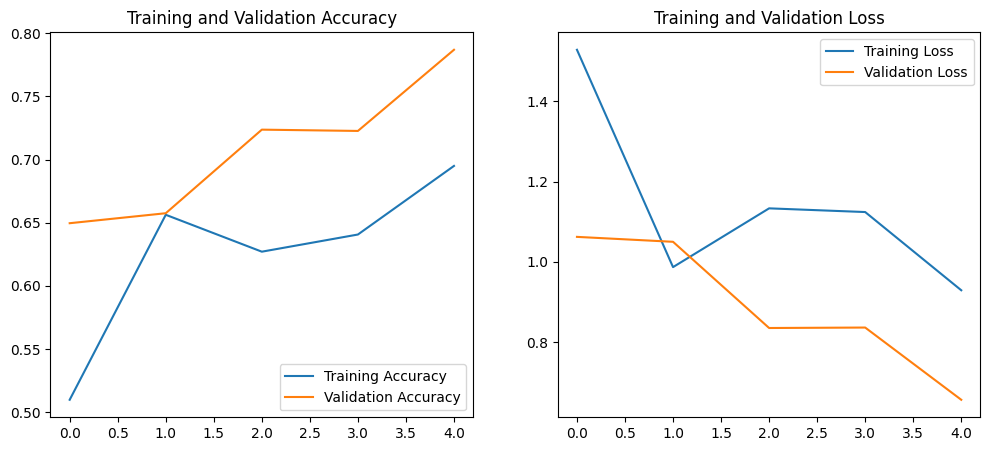


Évaluation du modèle: Base CNN
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 0.9819
Loss: 0.0731
Precision: 0.9857
Recall: 0.9834
F1-score: 0.9837

Évaluation du modèle: CNN with Data Augmentation
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.9555
Loss: 0.1290
Precision: 0.9535
Recall: 0.9514
F1-score: 0.9500

Évaluation du modèle: Best Tuned Model
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.9969
Loss: 0.0131
Precision: 0.9970
Recall: 0.9972
F1-score: 0.9970

Évaluation du modèle: VGG19 Transfer Learning
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Accuracy: 0.6496
Loss: 1.0622
Precision: 0.6597
Recall: 0.5614
F1-score: 0.5788


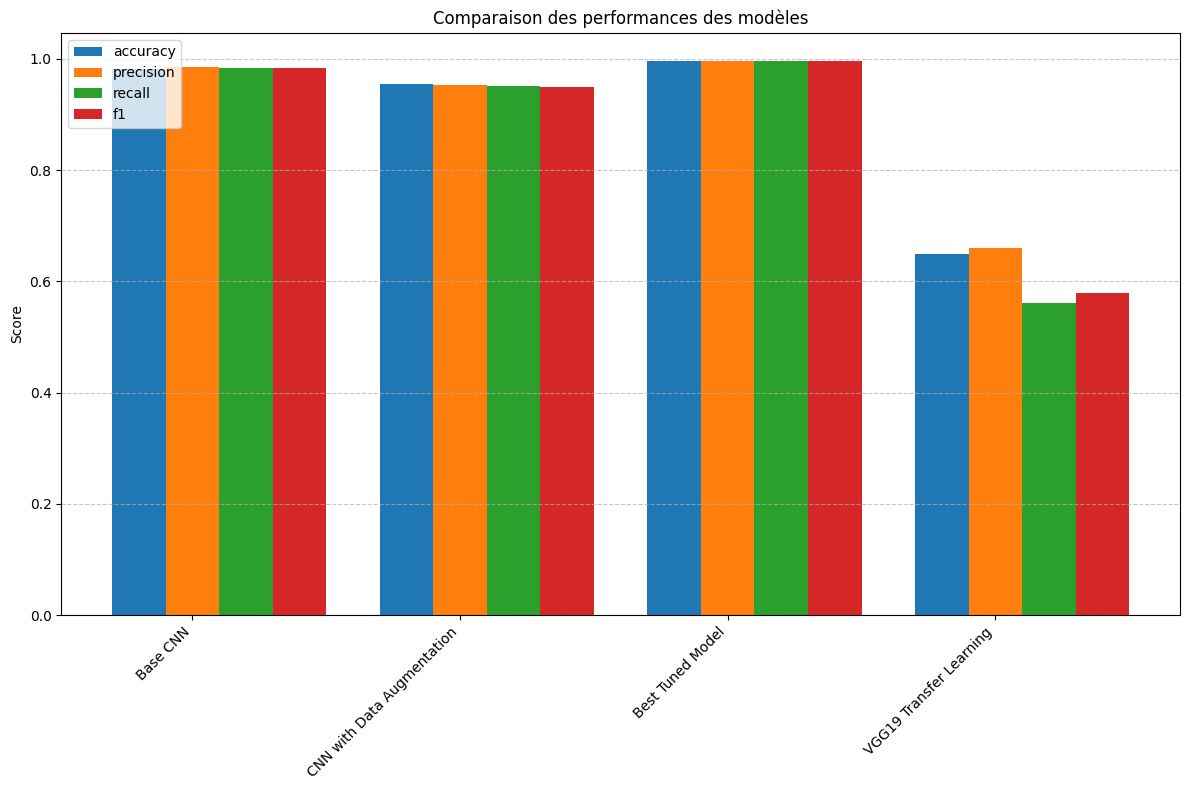

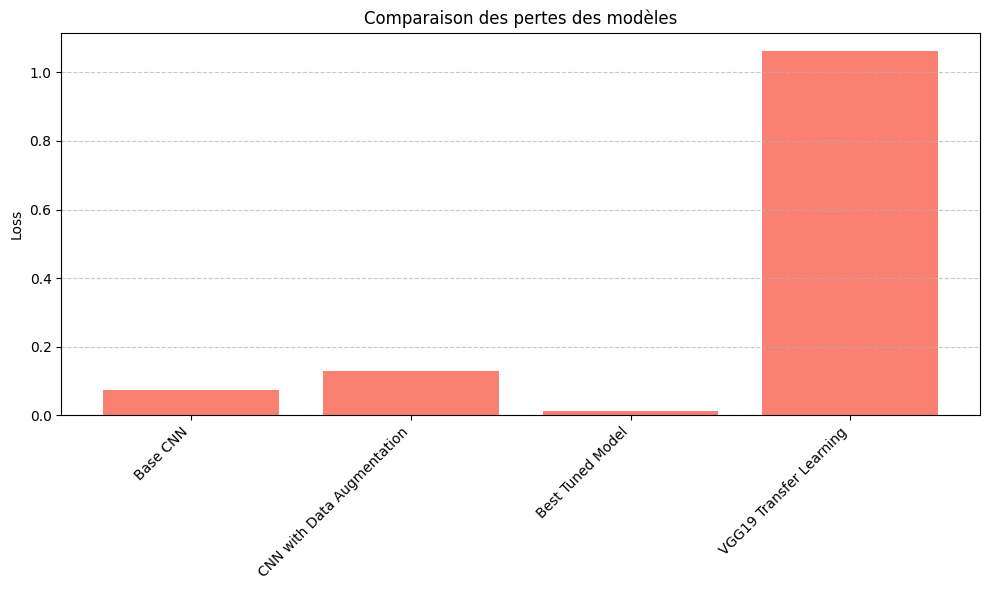

In [14]:
# Créer un modèle VGG19 pré-entraîné
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Geler toutes les couches du modèle pré-entraîné
for layer in base_model.layers:
    layer.trainable = False

# Ajouter des couches personnalisées en haut du modèle pré-entraîné
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(43, activation='softmax')(x)

# Créer le modèle final
vgg19_model = Model(inputs=base_model.input, outputs=predictions)

# Compiler le modèle
vgg19_model.compile(optimizer=Adam(learning_rate=0.001),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Afficher un résumé du modèle
vgg19_model.summary()

# Entraîner le modèle avec les données augmentées
history_vgg19 = vgg19_model.fit(
    it_train,
    steps_per_epoch=len(X_train) // 64,
    validation_data=(X_val, y_val),
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)

# Évaluer le modèle
evaluate_model(vgg19_model, X_val, y_val)
plot_training_curves(history_vgg19)

# Fine-tuning: Dégeler quelques couches pour l'apprentissage fin
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Recompiler le modèle avec un taux d'apprentissage plus faible
vgg19_model.compile(optimizer=Adam(learning_rate=0.0001),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Afficher un résumé du modèle pour confirmer quelles couches sont entraînables
vgg19_model.summary()

# Fine-tuning
history_vgg19_ft = vgg19_model.fit(
    it_train,
    steps_per_epoch=len(X_train) // 64,
    validation_data=(X_val, y_val),
    epochs=5,
    callbacks=[early_stopping, reduce_lr]
)

# Évaluer le modèle
evaluate_model(vgg19_model, X_val, y_val)
plot_training_curves(history_vgg19_ft)

# Comparer les performances de tous les modèles
# Créer un récapitulatif des performances des modèles
models = {
    "Base CNN": cnn,
    "CNN with Data Augmentation": model_2,
    "Best Tuned Model": best_model,
    "VGG19 Transfer Learning": vgg19_model
}

# Évaluer chaque modèle et stocker les résultats
results = {}
for name, model in models.items():
    print(f"\nÉvaluation du modèle: {name}")
    loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
    
    # Faire des prédictions
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_val, axis=1)
    
    # Calculer les métriques
    precision = precision_score(y_true_classes, y_pred_classes, average='macro')
    recall = recall_score(y_true_classes, y_pred_classes, average='macro')
    f1 = f1_score(y_true_classes, y_pred_classes, average='macro')
    
    results[name] = {
        "accuracy": accuracy,
        "loss": loss,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Loss: {loss:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

# Visualiser les résultats de comparaison
metrics = ["accuracy", "precision", "recall", "f1"]
model_names = list(results.keys())

plt.figure(figsize=(12, 8))
x = np.arange(len(model_names))
width = 0.2
multiplier = 0

for metric in metrics:
    values = [results[name][metric] for name in model_names]
    offset = width * multiplier
    rects = plt.bar(x + offset, values, width, label=metric)
    multiplier += 1

plt.ylabel('Score')
plt.title('Comparaison des performances des modèles')
plt.xticks(x + width, model_names, rotation=45, ha='right')
plt.legend(loc='upper left')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Visualiser la perte (loss) de chaque modèle
losses = [results[name]["loss"] for name in model_names]

plt.figure(figsize=(10, 6))
plt.bar(model_names, losses, color='salmon')
plt.ylabel('Loss')
plt.title('Comparaison des pertes des modèles')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()